In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 51.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 179.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 157.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 192.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 177.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 168.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 153.4 MB/s eta 0:00:00


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# 데이터 경로 설정
base_dir = '/home/ec2-user/SageMaker/preprocessed_noise_contrast'

# ResNet50에 맞는 데이터 변환
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기를 ResNet50에 맞게 조정
    transforms.ToTensor(),         # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet50 사전 학습에 사용된 정규화
])

# train, val, test 데이터셋 로드
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

class Evaluator:
    def __init__(self, model, test_loader, device):
        """
        Confusion Matrix 및 학습/평가 지표를 제공하는 클래스.

        Args:
        - model: PyTorch 모델.
        - test_loader: 테스트 데이터 로더.
        - device: 모델 디바이스 ('cuda' 또는 'cpu').
        """
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.y_true = []
        self.y_pred = []
        self.y_scores = []
        self.train_losses = []
        self.val_losses = []

    def evaluate(self):
        """모델 평가 - y_true, y_pred, y_scores 저장."""
        self.model.eval()
        self.y_true = []
        self.y_pred = []
        self.y_scores = []

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Positive class 확률
                _, predicted = torch.max(outputs, 1)
                
                self.y_true.extend(labels.cpu().numpy())
                self.y_pred.extend(predicted.cpu().numpy())
                self.y_scores.extend(probabilities.cpu().numpy())

    def plot_confusion_matrix(self):
        """Confusion Matrix 생성 및 시각화."""
        cm = confusion_matrix(self.y_true, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NG', 'OK'], yticklabels=['NG', 'OK'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    def print_classification_report(self):
        """Classification Report 출력."""
        print("Classification Report:")
        print(classification_report(self.y_true, self.y_pred, target_names=['NG', 'OK']))

    def plot_f1_score_curve(self):
        """F1-Score Curve 생성."""
        thresholds = np.linspace(0, 1, 100)
        f1_scores = []

        for threshold in thresholds:
            y_pred_threshold = (np.array(self.y_scores) >= threshold).astype(int)
            f1 = f1_score(self.y_true, y_pred_threshold)
            f1_scores.append(f1)

        plt.figure(figsize=(8, 6))
        plt.plot(thresholds, f1_scores, label="F1 Score")
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
        plt.title('F1 Score Curve')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_roc_curve(self):
        """ROC Curve 생성."""
        fpr, tpr, _ = roc_curve(self.y_true, self.y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'r--')  # 대각선 기준선
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    def plot_training_curves(self):
        """학습 및 검증 손실 곡선 시각화."""
        plt.figure(figsize=(8, 6))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid()
        plt.show()

    def update_training_loss(self, train_loss, val_loss):
        """훈련 중 손실값 업데이트."""
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)

In [6]:
# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class Weights: tensor([1.1815, 0.8669], device='cuda:0')
Epoch 1/15 | Train Loss: 0.8302 | Val Loss: 62.2398
Epoch 2/15 | Train Loss: 0.5517 | Val Loss: 2.3173
Epoch 3/15 | Train Loss: 0.3511 | Val Loss: 13.1932
No improvement in validation loss for 1 epochs.
Epoch 4/15 | Train Loss: 0.4955 | Val Loss: 2.1246
Epoch 5/15 | Train Loss: 0.2645 | Val Loss: 1.9645
Epoch 6/15 | Train Loss: 0.3412 | Val Loss: 0.8066
Epoch 7/15 | Train Loss: 0.1689 | Val Loss: 0.4134
Epoch 8/15 | Train Loss: 0.2503 | Val Loss: 0.5698
No improvement in validation loss for 1 epochs.
Epoch 9/15 | Train Loss: 0.3023 | Val Loss: 0.3163
Epoch 10/15 | Train Loss: 0.1724 | Val Loss: 1.6245
No improvement in validation loss for 1 epochs.
Epoch 11/15 | Train Loss: 0.2723 | Val Loss: 4.5327
No improvement in validation loss for 2 epochs.
Epoch 12/15 | Train Loss: 0.2201 | Val Loss: 1.0801
No improvement in validation loss for 3 epochs.
Epoch 13/15 | Train Loss: 0.1656 | Val Loss: 0.4937
No improvement in validation loss 

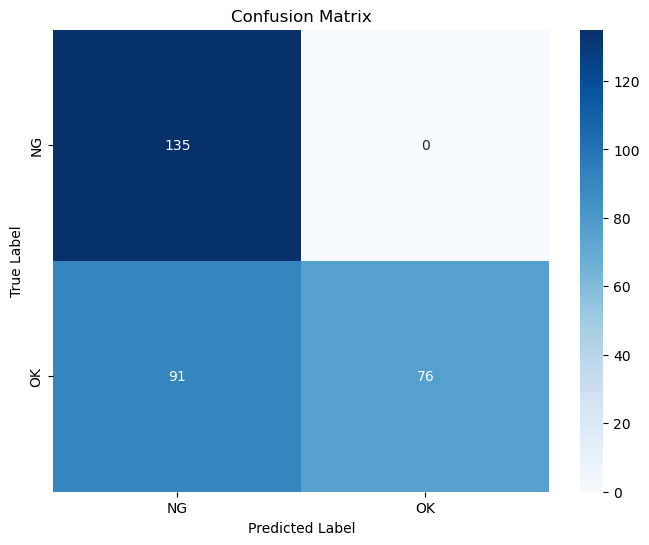

Classification Report:
              precision    recall  f1-score   support

          NG       0.60      1.00      0.75       135
          OK       1.00      0.46      0.63       167

    accuracy                           0.70       302
   macro avg       0.80      0.73      0.69       302
weighted avg       0.82      0.70      0.68       302



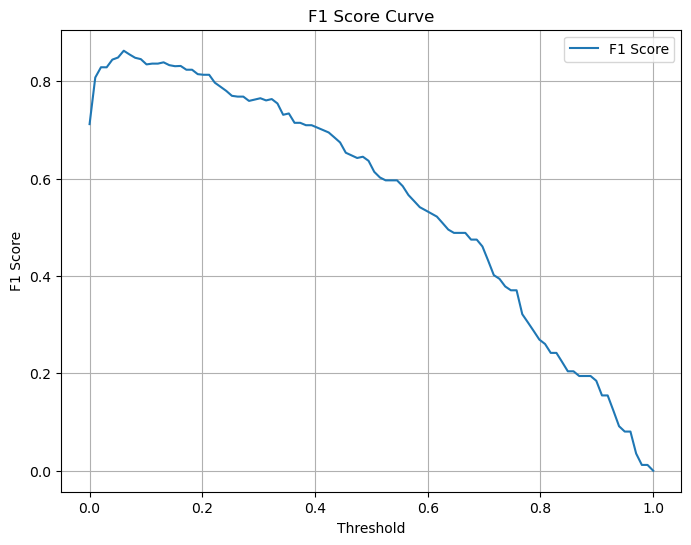

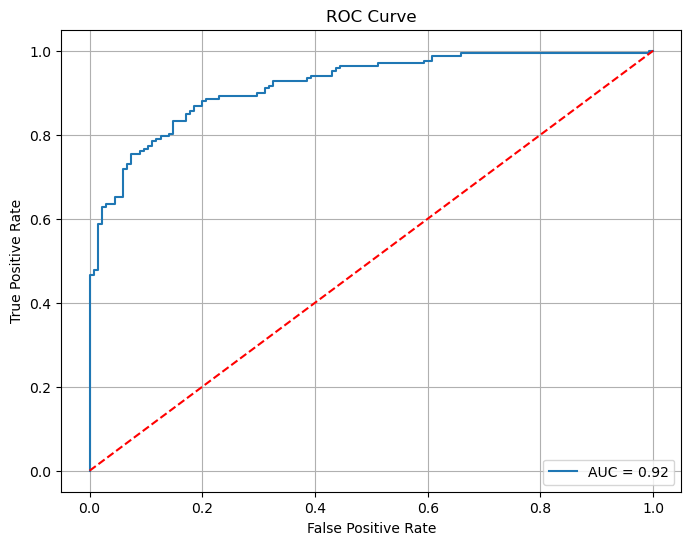

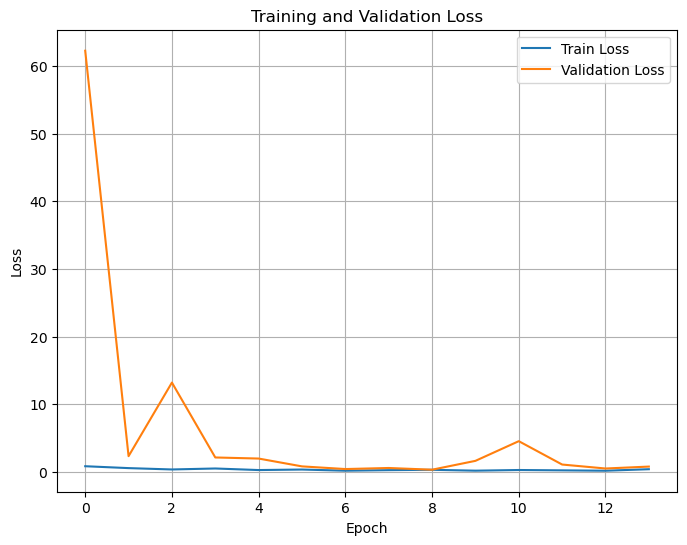

Test Accuracy: 69.87%


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ResNet 모델 설정
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 클래스 수: 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 데이터 증강 및 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 클래스별 가중치 계산
labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

# 손실 함수 정의
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ConfusionMatrixEvaluator 클래스 선언 (사용 중인 클래스 그대로 사용)
evaluator = Evaluator(model, test_loader, device)

# WeightedRandomSampler 사용
class_counts = np.bincount(labels)
sample_weights = [1.0 / class_counts[label] for label in labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader 수정 (WeightedRandomSampler 사용)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Early Stopping 설정
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 루프
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 에포크당 평균 학습 손실 계산
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:  # val_loader를 사용해 Validation Loss 계산
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)  # Validation Loss 평균

    # Training 및 Validation Loss 업데이트
    evaluator.update_training_loss(train_loss=avg_train_loss, val_loss=avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Early Stopping 조건 확인
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        # 모델 현재 상태 저장
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss for {early_stop_counter} epochs.")

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break
        
# 학습 종료 후 최종 모델 저장
torch.save(model.state_dict(), "best_model_50.pth")
print("Best model 50 saved as final_model_34.pth")
        

# 테스트 데이터 평가
evaluator.evaluate()

# Confusion Matrix 출력
evaluator.plot_confusion_matrix()

# Classification Report 출력
evaluator.print_classification_report()

# F1-Score Curve 출력
evaluator.plot_f1_score_curve()

# ROC Curve 출력
evaluator.plot_roc_curve()

# 학습 및 검증 손실 곡선 출력
evaluator.plot_training_curves()

# 정확도 출력
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:  # test_loader 사용
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")